# Import dependencies

In [1]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [2]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

            Date Country  Province  Infected  Deaths  Recovered
16404 2020-04-18      US   Wyoming       307       2          0
16405 2020-04-18   China  Xinjiang         0       3         73
16406 2020-04-18  Canada     Yukon         9       0          0
16407 2020-04-18   China    Yunnan         5       2        177
16408 2020-04-18   China  Zhejiang        21       1       1246
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16409 entries, 0 to 16408
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       16409 non-null  datetime64[ns]
 1   Country    16409 non-null  object        
 2   Province   16409 non-null  object        
 3   Infected   16409 non-null  int64         
 4   Deaths     16409 non-null  int64         
 5   Recovered  16409 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 769.3+ KB
None


'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

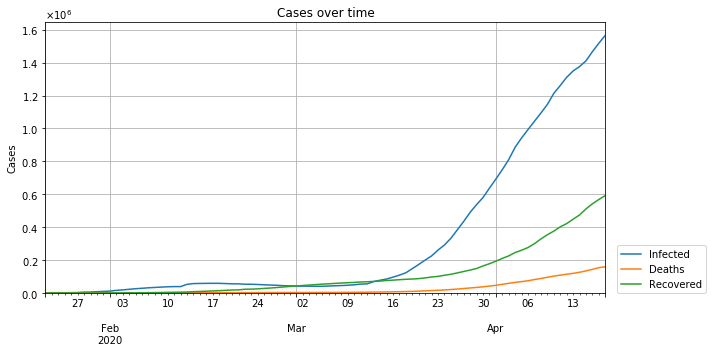

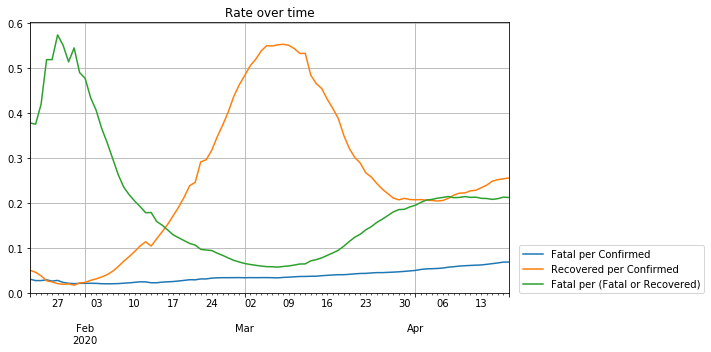

In [3]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

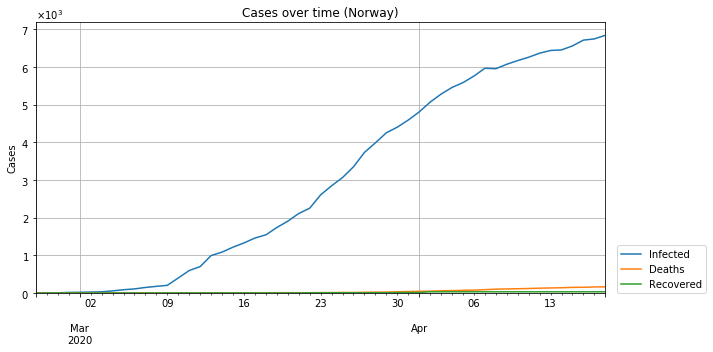

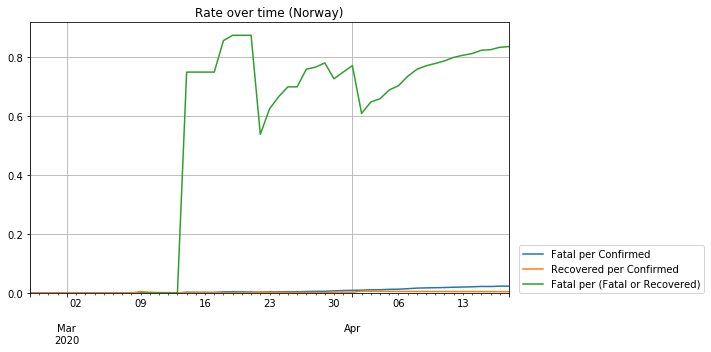

In [4]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [5]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

/Users/adil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

## The SIR epidemic model

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three "compartments" which may vary as a function of time, $t$:

 * $S(t)$: Susceptible       (= All - Confirmed)
 * $I(t)$: Infected          (= Confirmed - Recovered - Deaths)
 * $R(t)$: Recovered or Died (= Recovered + Deaths)
 
 

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 

* $\beta$ describes the effective contact rate of the disease: an infected individual comes into contact with $\beta N$ other individuals per unit time (of which the fraction that are susceptible to contracting the disease is $S/N$). 

* $\gamma$ is the mean recovery rate: that is, $1/\gamma$ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:


$$\frac{dS}{dT}=\frac{-\beta}{N}SI$$

$$\frac{dI}{dT}=\frac{\beta SI}{N}-\gamma I$$

$$\frac{dR}{dT}=\gamma I$$

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

<a href="https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/">Sample code</a>


## Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$$\frac{dx}{dt}= - \rho x y$$  
$$\frac{dy}{dt}= \rho x y - \sigma y$$  
$$\frac{dz}{dt}= \sigma y$$

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

In [6]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 125280]


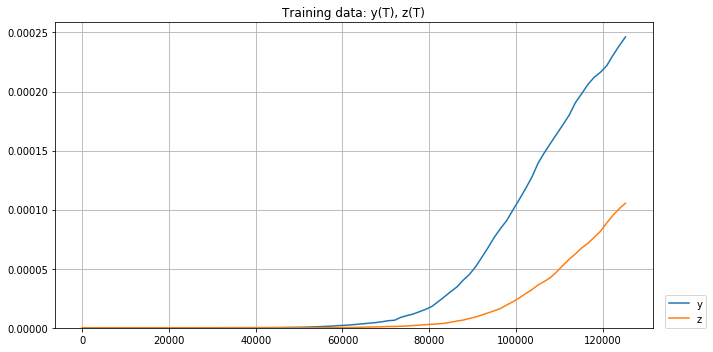

In [7]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [8]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [9]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 6.75 ms, sys: 1.42 ms, total: 8.17 ms
Wall time: 6.82 ms


,t,x,y,z
296,296,0.108567,0.000636,0.890797
297,297,0.108554,0.000600,0.890846
298,298,0.108541,0.000566,0.890893
299,299,0.108529,0.000534,0.890937
300,300,0.108518,0.000504,0.890978


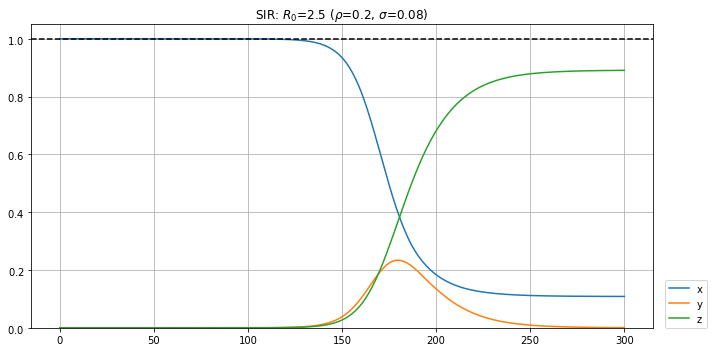

In [10]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [11]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-04-19 14:35:57,011] Finished trial#7 resulted in value: 11752979374.170519. Current best value is 11752979374.170519 with parameters: {'tau': 724, 'rho': 0.05699396231850111, 'sigma': 0.01249737178391145}.
[I 2020-04-19 14:35:57,190] Finished trial#5 resulted in value: 12147353710.6744. Current best value is 11752979374.170519 with parameters: {'tau': 724, 'rho': 0.05699396231850111, 'sigma': 0.01249737178391145}.
[I 2020-04-19 14:35:57,251] Finished trial#1 resulted in value: 12854232023.024342. Current best value is 11752979374.170519 with parameters: {'tau': 724, 'rho': 0.05699396231850111, 'sigma': 0.01249737178391145}.
[I 2020-04-19 14:35:57,251] Finished trial#0 resulted in value: 12396613820.766232. Current best value is 11752979374.170519 with parameters: {'tau': 724, 'rho': 0.05699396231850111, 'sigma': 0.01249737178391145}.
[I 2020-04-19 14:35:57,254] Finished trial#4 resulted in value: 11410183541.940384. Current best value is 11410183541.940384 with parameters: {'ta

[I 2020-04-19 14:36:00,208] Finished trial#38 resulted in value: 11759811057.275602. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:00,273] Finished trial#37 resulted in value: 12009424567.03506. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:00,424] Finished trial#35 resulted in value: 11482155507.412588. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:00,540] Finished trial#40 resulted in value: 20969646508.947742. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:00,609] Finished trial#39 resulted in value: 11778671864.194948. Current best value is 9912444677.575623 with paramet

[I 2020-04-19 14:36:03,709] Finished trial#71 resulted in value: 12273185646.09027. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:03,782] Finished trial#78 resulted in value: 12106656178.567274. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:03,916] Finished trial#68 resulted in value: 24904507846.998074. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:03,997] Finished trial#75 resulted in value: 12203178250.319542. Current best value is 9912444677.575623 with parameters: {'tau': 40, 'rho': 0.004590373774148684, 'sigma': 0.0007254493042748195}.
[I 2020-04-19 14:36:04,099] Finished trial#76 resulted in value: 12246465765.034616. Current best value is 9912444677.575623 with paramet

[I 2020-04-19 14:36:07,121] Finished trial#114 resulted in value: 12635798918.462952. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:07,208] Finished trial#111 resulted in value: 10822929656.585417. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:07,281] Finished trial#110 resulted in value: 11706916119.230562. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:07,357] Finished trial#115 resulted in value: 11025353671.989452. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:07,450] Finished trial#109 resulted in value: 11501387428.418175. Current best value is 9684659821.195957 with p

[I 2020-04-19 14:36:10,494] Finished trial#136 resulted in value: 11820755418.831102. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:10,619] Finished trial#141 resulted in value: 11918772539.071669. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:10,702] Finished trial#153 resulted in value: 15275532376.670265. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:10,804] Finished trial#155 resulted in value: 11623423833.740791. Current best value is 9684659821.195957 with parameters: {'tau': 1228, 'rho': 0.15831997042720114, 'sigma': 0.022820098705435204}.
[I 2020-04-19 14:36:10,886] Finished trial#151 resulted in value: 17953370888.78153. Current best value is 9684659821.195957 with pa

[I 2020-04-19 14:36:13,920] Finished trial#180 resulted in value: 9915083927.721718. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:14,004] Finished trial#187 resulted in value: 9671994375.19762. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:14,082] Finished trial#183 resulted in value: 9979749848.698458. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:14,158] Finished trial#184 resulted in value: 9730085947.749014. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:14,235] Finished trial#186 resulted in value: 10182593152.282536. Current best value is 9263030887.167068 with parame

[I 2020-04-19 14:36:17,422] Finished trial#218 resulted in value: 9818623696.97778. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:17,508] Finished trial#219 resulted in value: 9766815626.851505. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:17,603] Finished trial#216 resulted in value: 10090967762.283903. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:17,707] Finished trial#217 resulted in value: 10114367116.185339. Current best value is 9263030887.167068 with parameters: {'tau': 1256, 'rho': 0.16285688378082766, 'sigma': 0.021350486255073988}.
[I 2020-04-19 14:36:17,796] Finished trial#221 resulted in value: 9809800017.634293. Current best value is 9263030887.167068 with param

[I 2020-04-19 14:36:21,107] Finished trial#255 resulted in value: 9859608221.374105. Current best value is 9245377600.08959 with parameters: {'tau': 1374, 'rho': 0.16577233075344702, 'sigma': 0.018339499765832178}.
[I 2020-04-19 14:36:21,244] Finished trial#252 resulted in value: 9256930594.40733. Current best value is 9245377600.08959 with parameters: {'tau': 1374, 'rho': 0.16577233075344702, 'sigma': 0.018339499765832178}.
[I 2020-04-19 14:36:21,336] Finished trial#258 resulted in value: 9750920860.946524. Current best value is 9245377600.08959 with parameters: {'tau': 1374, 'rho': 0.16577233075344702, 'sigma': 0.018339499765832178}.
[I 2020-04-19 14:36:21,391] Finished trial#257 resulted in value: 9258253246.53731. Current best value is 9245377600.08959 with parameters: {'tau': 1374, 'rho': 0.16577233075344702, 'sigma': 0.018339499765832178}.
[I 2020-04-19 14:36:21,577] Finished trial#256 resulted in value: 9698690046.76344. Current best value is 9245377600.08959 with parameters: {'

[I 2020-04-19 14:36:24,991] Finished trial#288 resulted in value: 9318756317.78782. Current best value is 9213355588.602673 with parameters: {'tau': 1301, 'rho': 0.16050774221957956, 'sigma': 0.016936415371756098}.
[I 2020-04-19 14:36:25,084] Finished trial#291 resulted in value: 9376585535.291113. Current best value is 9213355588.602673 with parameters: {'tau': 1301, 'rho': 0.16050774221957956, 'sigma': 0.016936415371756098}.
[I 2020-04-19 14:36:25,198] Finished trial#293 resulted in value: 9238166290.796888. Current best value is 9213355588.602673 with parameters: {'tau': 1301, 'rho': 0.16050774221957956, 'sigma': 0.016936415371756098}.
[I 2020-04-19 14:36:25,299] Finished trial#294 resulted in value: 9241517120.989239. Current best value is 9213355588.602673 with parameters: {'tau': 1301, 'rho': 0.16050774221957956, 'sigma': 0.016936415371756098}.
[I 2020-04-19 14:36:25,398] Finished trial#292 resulted in value: 9251059544.404583. Current best value is 9213355588.602673 with paramet

[I 2020-04-19 14:36:29,014] Finished trial#323 resulted in value: 9175207090.78778. Current best value is 9166657921.928156 with parameters: {'tau': 1278, 'rho': 0.15862105662075116, 'sigma': 0.01590296629350454}.
[I 2020-04-19 14:36:29,100] Finished trial#322 resulted in value: 9240669242.199131. Current best value is 9166657921.928156 with parameters: {'tau': 1278, 'rho': 0.15862105662075116, 'sigma': 0.01590296629350454}.
[I 2020-04-19 14:36:29,193] Finished trial#327 resulted in value: 9237424786.98044. Current best value is 9166657921.928156 with parameters: {'tau': 1278, 'rho': 0.15862105662075116, 'sigma': 0.01590296629350454}.
[I 2020-04-19 14:36:29,339] Finished trial#328 resulted in value: 9214525272.94491. Current best value is 9166657921.928156 with parameters: {'tau': 1278, 'rho': 0.15862105662075116, 'sigma': 0.01590296629350454}.
[I 2020-04-19 14:36:29,493] Finished trial#324 resulted in value: 9224729802.73714. Current best value is 9166657921.928156 with parameters: {'

[I 2020-04-19 14:36:33,186] Finished trial#354 resulted in value: 11083712772.842777. Current best value is 9152113118.213432 with parameters: {'tau': 1277, 'rho': 0.1587284810627356, 'sigma': 0.01562538052707926}.
[I 2020-04-19 14:36:33,338] Finished trial#361 resulted in value: 9632478910.28291. Current best value is 9152113118.213432 with parameters: {'tau': 1277, 'rho': 0.1587284810627356, 'sigma': 0.01562538052707926}.
[I 2020-04-19 14:36:33,430] Finished trial#363 resulted in value: 9589504272.989418. Current best value is 9152113118.213432 with parameters: {'tau': 1277, 'rho': 0.1587284810627356, 'sigma': 0.01562538052707926}.
[I 2020-04-19 14:36:33,578] Finished trial#358 resulted in value: 10898719301.24245. Current best value is 9152113118.213432 with parameters: {'tau': 1277, 'rho': 0.1587284810627356, 'sigma': 0.01562538052707926}.
[I 2020-04-19 14:36:33,667] Finished trial#365 resulted in value: 9982545615.45955. Current best value is 9152113118.213432 with parameters: {'t

[I 2020-04-19 14:36:37,529] Finished trial#397 resulted in value: 9039428844.305721. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:37,623] Finished trial#399 resulted in value: 9071973975.568474. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:37,743] Finished trial#401 resulted in value: 9055766312.506956. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:37,995] Finished trial#402 resulted in value: 9053373029.91915. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:38,089] Finished trial#403 resulted in value: 9084614046.949999. Current best value is 9020960074.131306 with parameters:

[I 2020-04-19 14:36:42,330] Finished trial#429 resulted in value: 9167460657.835785. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:42,466] Finished trial#438 resulted in value: 9071626165.587475. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:42,572] Finished trial#441 resulted in value: 9082846679.516956. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:42,720] Finished trial#437 resulted in value: 9118104473.130568. Current best value is 9020960074.131306 with parameters: {'tau': 1317, 'rho': 0.16116748451318866, 'sigma': 0.01438577234169498}.
[I 2020-04-19 14:36:42,880] Finished trial#440 resulted in value: 9152922796.682714. Current best value is 9020960074.131306 with parameters

[I 2020-04-19 14:36:47,242] Finished trial#479 resulted in value: 9103227587.99571. Current best value is 8918121581.988663 with parameters: {'tau': 1364, 'rho': 0.16366443686487162, 'sigma': 0.014009808209143708}.
[I 2020-04-19 14:36:47,340] Finished trial#480 resulted in value: 9067299178.872395. Current best value is 8918121581.988663 with parameters: {'tau': 1364, 'rho': 0.16366443686487162, 'sigma': 0.014009808209143708}.
[I 2020-04-19 14:36:47,552] Finished trial#483 resulted in value: 9168996045.73346. Current best value is 8918121581.988663 with parameters: {'tau': 1364, 'rho': 0.16366443686487162, 'sigma': 0.014009808209143708}.
[I 2020-04-19 14:36:47,661] Finished trial#436 resulted in value: 23596399716.1144. Current best value is 8918121581.988663 with parameters: {'tau': 1364, 'rho': 0.16366443686487162, 'sigma': 0.014009808209143708}.
[I 2020-04-19 14:36:47,878] Finished trial#485 resulted in value: 9202746993.436834. Current best value is 8918121581.988663 with parameter

CPU times: user 57.7 s, sys: 7.48 s, total: 1min 5s
Wall time: 54.7 s


/Users/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



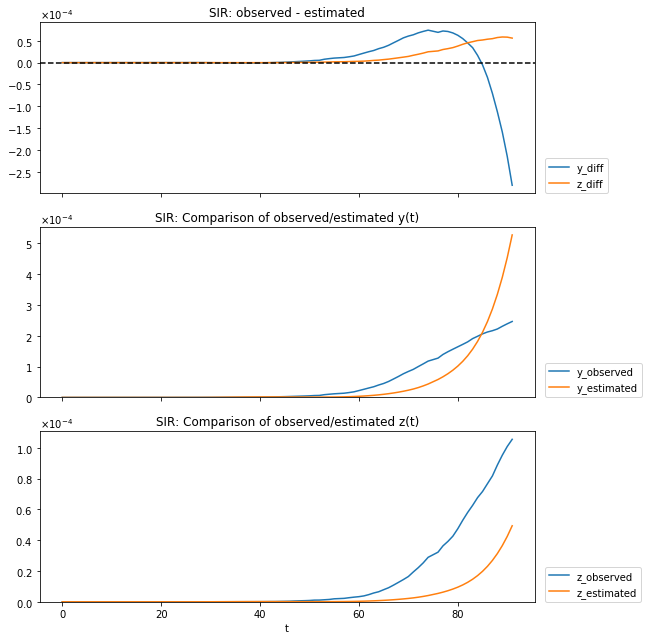

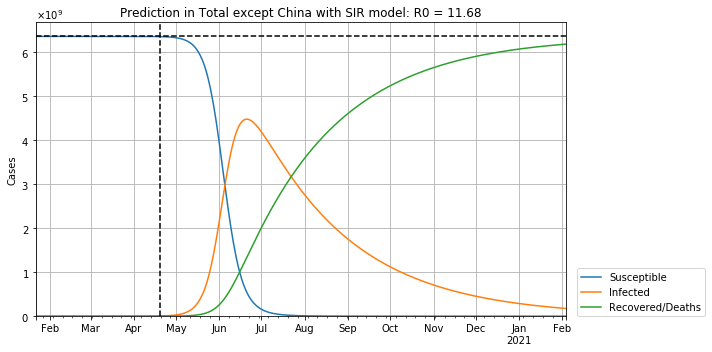

In [12]:
sir_estimater.history_df().head()
#sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [13]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-04-19 14:36:53,730] Finished trial#6 resulted in value: 501311971914.71075. Current best value is 501311971914.71075 with parameters: {'tau': 520, 'kappa': 0.0021498924338887028, 'rho': 0.05812744217334279, 'sigma': 0.006179347760914187}.
[I 2020-04-19 14:36:53,798] Finished trial#8 resulted in value: 129320850172.62396. Current best value is 129320850172.62396 with parameters: {'tau': 852, 'kappa': 0.0034322937531988213, 'rho': 0.06767116129911353, 'sigma': 0.007232893770391368}.
[I 2020-04-19 14:36:53,980] Finished trial#5 resulted in value: 324584451177.921. Current best value is 129320850172.62396 with parameters: {'tau': 852, 'kappa': 0.0034322937531988213, 'rho': 0.06767116129911353, 'sigma': 0.007232893770391368}.
[I 2020-04-19 14:36:53,982] Finished trial#4 resulted in value: 270834272646.88522. Current best value is 129320850172.62396 with parameters: {'tau': 852, 'kappa': 0.0034322937531988213, 'rho': 0.06767116129911353, 'sigma': 0.007232893770391368}.
[I 2020-04-19 

[I 2020-04-19 14:36:56,313] Finished trial#30 resulted in value: 115463802956.13611. Current best value is 115463802956.13611 with parameters: {'tau': 1261, 'kappa': 0.004512372029229354, 'rho': 0.1571952114398559, 'sigma': 0.016178637106180012}.
[I 2020-04-19 14:36:56,386] Finished trial#31 resulted in value: 129789710034.03548. Current best value is 115463802956.13611 with parameters: {'tau': 1261, 'kappa': 0.004512372029229354, 'rho': 0.1571952114398559, 'sigma': 0.016178637106180012}.
[I 2020-04-19 14:36:56,445] Finished trial#35 resulted in value: 127500677851.98058. Current best value is 115463802956.13611 with parameters: {'tau': 1261, 'kappa': 0.004512372029229354, 'rho': 0.1571952114398559, 'sigma': 0.016178637106180012}.
[I 2020-04-19 14:36:56,523] Finished trial#34 resulted in value: 121399579658.64085. Current best value is 115463802956.13611 with parameters: {'tau': 1261, 'kappa': 0.004512372029229354, 'rho': 0.1571952114398559, 'sigma': 0.016178637106180012}.
[I 2020-04-1

[I 2020-04-19 14:36:59,196] Finished trial#67 resulted in value: 147108718293.20203. Current best value is 112326228529.59622 with parameters: {'tau': 1343, 'kappa': 0.0024802972525902424, 'rho': 0.1608778941277576, 'sigma': 0.01710801775797532}.
[I 2020-04-19 14:36:59,293] Finished trial#70 resulted in value: 214214347078.15155. Current best value is 112326228529.59622 with parameters: {'tau': 1343, 'kappa': 0.0024802972525902424, 'rho': 0.1608778941277576, 'sigma': 0.01710801775797532}.
[I 2020-04-19 14:36:59,387] Finished trial#62 resulted in value: 133859053639.61833. Current best value is 112326228529.59622 with parameters: {'tau': 1343, 'kappa': 0.0024802972525902424, 'rho': 0.1608778941277576, 'sigma': 0.01710801775797532}.
[I 2020-04-19 14:36:59,483] Finished trial#73 resulted in value: 115643031431.16557. Current best value is 112326228529.59622 with parameters: {'tau': 1343, 'kappa': 0.0024802972525902424, 'rho': 0.1608778941277576, 'sigma': 0.01710801775797532}.
[I 2020-04-1

[I 2020-04-19 14:37:02,330] Finished trial#102 resulted in value: 115528197402.69502. Current best value is 105442084580.94672 with parameters: {'tau': 1308, 'kappa': 0.001932520246675531, 'rho': 0.16240106059455708, 'sigma': 0.016940452037848084}.
[I 2020-04-19 14:37:02,391] Finished trial#105 resulted in value: 110197102747.43987. Current best value is 105442084580.94672 with parameters: {'tau': 1308, 'kappa': 0.001932520246675531, 'rho': 0.16240106059455708, 'sigma': 0.016940452037848084}.
[I 2020-04-19 14:37:02,485] Finished trial#103 resulted in value: 109913408289.53285. Current best value is 105442084580.94672 with parameters: {'tau': 1308, 'kappa': 0.001932520246675531, 'rho': 0.16240106059455708, 'sigma': 0.016940452037848084}.
[I 2020-04-19 14:37:02,562] Finished trial#106 resulted in value: 109961141463.64188. Current best value is 105442084580.94672 with parameters: {'tau': 1308, 'kappa': 0.001932520246675531, 'rho': 0.16240106059455708, 'sigma': 0.016940452037848084}.
[I 2

[I 2020-04-19 14:37:05,633] Finished trial#138 resulted in value: 113860770611.72145. Current best value is 105318247518.58746 with parameters: {'tau': 1240, 'kappa': 0.0017869970610912222, 'rho': 0.15488700582553766, 'sigma': 0.013575147969346299}.
[I 2020-04-19 14:37:05,714] Finished trial#137 resulted in value: 119605646443.32254. Current best value is 105318247518.58746 with parameters: {'tau': 1240, 'kappa': 0.0017869970610912222, 'rho': 0.15488700582553766, 'sigma': 0.013575147969346299}.
[I 2020-04-19 14:37:05,828] Finished trial#134 resulted in value: 153485448681.1248. Current best value is 105318247518.58746 with parameters: {'tau': 1240, 'kappa': 0.0017869970610912222, 'rho': 0.15488700582553766, 'sigma': 0.013575147969346299}.
[I 2020-04-19 14:37:05,951] Finished trial#136 resulted in value: 170475006586.74216. Current best value is 105318247518.58746 with parameters: {'tau': 1240, 'kappa': 0.0017869970610912222, 'rho': 0.15488700582553766, 'sigma': 0.013575147969346299}.
[

[I 2020-04-19 14:37:09,272] Finished trial#167 resulted in value: 126992519020.8587. Current best value is 103263631797.10753 with parameters: {'tau': 1265, 'kappa': 0.0015219041492703681, 'rho': 0.15946428117366387, 'sigma': 0.014160060458631829}.
[I 2020-04-19 14:37:09,398] Finished trial#169 resulted in value: 134939987987.4121. Current best value is 103263631797.10753 with parameters: {'tau': 1265, 'kappa': 0.0015219041492703681, 'rho': 0.15946428117366387, 'sigma': 0.014160060458631829}.
[I 2020-04-19 14:37:09,532] Finished trial#170 resulted in value: 149688343982.19864. Current best value is 103263631797.10753 with parameters: {'tau': 1265, 'kappa': 0.0015219041492703681, 'rho': 0.15946428117366387, 'sigma': 0.014160060458631829}.
[I 2020-04-19 14:37:09,613] Finished trial#171 resulted in value: 102084266761.93399. Current best value is 102084266761.93399 with parameters: {'tau': 1318, 'kappa': 0.0018040502670813112, 'rho': 0.15961391191872118, 'sigma': 0.013105922003841404}.
[I

[I 2020-04-19 14:37:13,101] Finished trial#198 resulted in value: 102612125192.00294. Current best value is 101663001698.61386 with parameters: {'tau': 1318, 'kappa': 0.0020907499463198483, 'rho': 0.16054494525759916, 'sigma': 0.01293404388789429}.
[I 2020-04-19 14:37:13,187] Finished trial#199 resulted in value: 103070856285.5163. Current best value is 101663001698.61386 with parameters: {'tau': 1318, 'kappa': 0.0020907499463198483, 'rho': 0.16054494525759916, 'sigma': 0.01293404388789429}.
[I 2020-04-19 14:37:13,280] Finished trial#200 resulted in value: 102730119054.76823. Current best value is 101663001698.61386 with parameters: {'tau': 1318, 'kappa': 0.0020907499463198483, 'rho': 0.16054494525759916, 'sigma': 0.01293404388789429}.
[I 2020-04-19 14:37:13,408] Finished trial#201 resulted in value: 102648930688.52248. Current best value is 101663001698.61386 with parameters: {'tau': 1318, 'kappa': 0.0020907499463198483, 'rho': 0.16054494525759916, 'sigma': 0.01293404388789429}.
[I 20

[I 2020-04-19 14:37:16,563] Finished trial#157 resulted in value: 129715662782.37599. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:16,716] Finished trial#227 resulted in value: 104818592573.73259. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:16,798] Finished trial#229 resulted in value: 106661489467.84634. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:16,886] Finished trial#230 resulted in value: 101965026810.5528. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-0

[I 2020-04-19 14:37:20,126] Finished trial#256 resulted in value: 103912419616.84477. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:20,213] Finished trial#260 resulted in value: 100610782515.28688. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:20,301] Finished trial#259 resulted in value: 100765855190.2338. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:20,447] Finished trial#258 resulted in value: 103934591528.5857. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04

[I 2020-04-19 14:37:23,827] Finished trial#290 resulted in value: 101974303645.5883. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:23,942] Finished trial#289 resulted in value: 103255850895.00491. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:24,034] Finished trial#287 resulted in value: 101409177076.15987. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:24,177] Finished trial#292 resulted in value: 128878047302.72552. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-0

[I 2020-04-19 14:37:27,680] Finished trial#321 resulted in value: 100418206945.0776. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:27,841] Finished trial#323 resulted in value: 101038006181.41281. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:27,943] Finished trial#325 resulted in value: 102904002756.94023. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-04-19 14:37:28,106] Finished trial#324 resulted in value: 104457272463.60797. Current best value is 100362351029.08618 with parameters: {'tau': 1358, 'kappa': 0.0025419835785193954, 'rho': 0.16510383004053397, 'sigma': 0.0120639285273198}.
[I 2020-0

[I 2020-04-19 14:37:31,770] Finished trial#357 resulted in value: 100776997940.6536. Current best value is 99855357588.06535 with parameters: {'tau': 1361, 'kappa': 0.002165898098608499, 'rho': 0.1622922100492203, 'sigma': 0.010975806312963993}.
[I 2020-04-19 14:37:31,888] Finished trial#358 resulted in value: 101847176120.61256. Current best value is 99855357588.06535 with parameters: {'tau': 1361, 'kappa': 0.002165898098608499, 'rho': 0.1622922100492203, 'sigma': 0.010975806312963993}.
[I 2020-04-19 14:37:31,986] Finished trial#359 resulted in value: 101935467908.41249. Current best value is 99855357588.06535 with parameters: {'tau': 1361, 'kappa': 0.002165898098608499, 'rho': 0.1622922100492203, 'sigma': 0.010975806312963993}.
[I 2020-04-19 14:37:32,216] Finished trial#318 resulted in value: 135700385713.96306. Current best value is 99855357588.06535 with parameters: {'tau': 1361, 'kappa': 0.002165898098608499, 'rho': 0.1622922100492203, 'sigma': 0.010975806312963993}.
[I 2020-04-19

[I 2020-04-19 14:37:36,307] Finished trial#341 resulted in value: 170400625249.8439. Current best value is 99624768934.35313 with parameters: {'tau': 1374, 'kappa': 0.0022250950530203813, 'rho': 0.16600008854596382, 'sigma': 0.01227904302938299}.
[I 2020-04-19 14:37:36,446] Finished trial#391 resulted in value: 101813687648.95538. Current best value is 99624768934.35313 with parameters: {'tau': 1374, 'kappa': 0.0022250950530203813, 'rho': 0.16600008854596382, 'sigma': 0.01227904302938299}.
[I 2020-04-19 14:37:36,618] Finished trial#393 resulted in value: 100489104236.79678. Current best value is 99624768934.35313 with parameters: {'tau': 1374, 'kappa': 0.0022250950530203813, 'rho': 0.16600008854596382, 'sigma': 0.01227904302938299}.
[I 2020-04-19 14:37:36,797] Finished trial#316 resulted in value: 169562042195.93512. Current best value is 99624768934.35313 with parameters: {'tau': 1374, 'kappa': 0.0022250950530203813, 'rho': 0.16600008854596382, 'sigma': 0.01227904302938299}.
[I 2020-0

[I 2020-04-19 14:37:40,949] Finished trial#425 resulted in value: 116562230710.9116. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:41,056] Finished trial#423 resulted in value: 115429016853.03848. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:41,166] Finished trial#424 resulted in value: 103115419532.59334. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:41,336] Finished trial#426 resulted in value: 103213275638.46342. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-0

[I 2020-04-19 14:37:45,723] Finished trial#454 resulted in value: 101123118661.07576. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:45,836] Finished trial#453 resulted in value: 101735346967.9144. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:46,033] Finished trial#452 resulted in value: 105554350371.78186. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:46,152] Finished trial#456 resulted in value: 103790801253.03183. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-0

[I 2020-04-19 14:37:50,886] Finished trial#486 resulted in value: 103950546144.76721. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:51,065] Finished trial#488 resulted in value: 113543628747.95213. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:51,236] Finished trial#489 resulted in value: 104132519169.72722. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-04-19 14:37:51,390] Finished trial#492 resulted in value: 99960987000.41322. Current best value is 99398191743.35416 with parameters: {'tau': 1358, 'kappa': 0.0020430841587460113, 'rho': 0.1660157570460832, 'sigma': 0.011874793820180383}.
[I 2020-0

CPU times: user 59.1 s, sys: 4.75 s, total: 1min 3s
Wall time: 1min


/Users/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



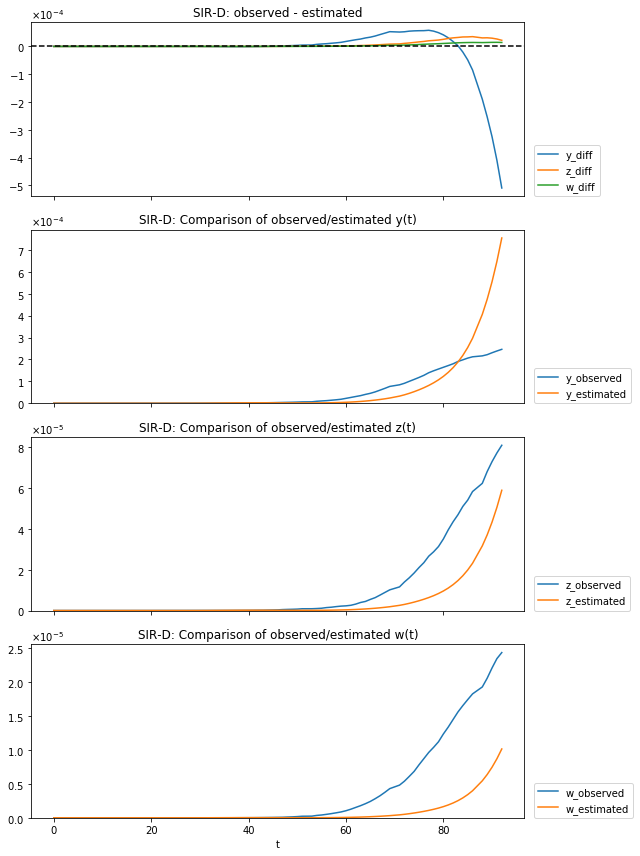

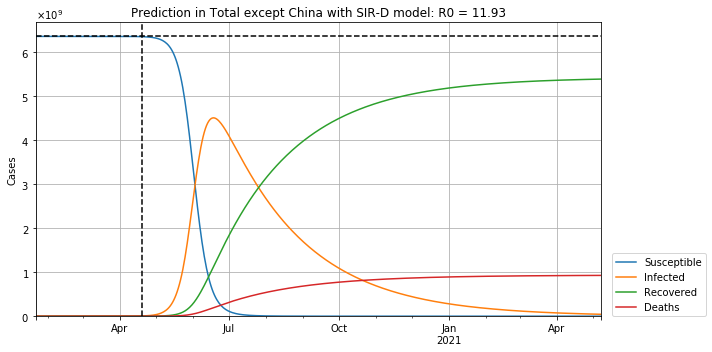

In [14]:
#sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)

# References

Further Reading

* M. J. Keeling and P. Rohani, <a href="http://press.princeton.edu/titles/8459.html">Modeling Infectious Diseases in Humans and Animals</a>, Princeton (2007).
* R. M. Anderson and R. M. May, <a href="http://www.amazon.co.uk/Infectious-Diseases-Humans-Dynamics-Publications/dp/019854040X">Infectious Diseases of Humans: Dynamics and Control,</a> OUP (1992).